In [16]:
# Imports
import numpy as np
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
import sklearn
import lightgbm as lgb  # brew install lightgbm (on MacOS)
import pickle
from IPython.display import Image
from subprocess import call

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz

# Load data

In [17]:
train = pd.read_csv(os.path.join("cs5228", "train.csv"))
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
(24421, 13) (24421, 13)


# Preprocessing

1) Drop NaN from train set (did not remove duplicates)

2) Combine capital gain and loss into one feature

3) Drop fnlweight and education

4) One-hot encoding


In [18]:
print(train.shape)
train.replace(" ?", np.nan, inplace=True)
train = train.dropna()
print(train.shape)

(24421, 14)
(22633, 14)


In [19]:
print(train.shape)
train["capital-gain-loss"] = train["capital-gain"] - train["capital-loss"]
train.drop(["capital-gain", "capital-loss"], axis=1, inplace=True)
train.drop(["fnlwgt", "education"], axis=1, inplace=True)
print(train.shape)

(22633, 14)
(22633, 11)


In [20]:
X_train = train.drop(["exceeds50K"], axis=1)
y_train = train["exceeds50K"]
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(list(X_train.columns))
print(X_train.shape, X_test.shape)

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country', 'capital-gain-loss']
(22633, 10) (24421, 13)


In [21]:
# One-hot-encoding
X_train = pd.get_dummies(X_train)

In [23]:
print(X_train.shape)
X_train.head()

(22633, 80)


age  education-num  hours-per-week  capital-gain-loss  \
1   60             13              42                  0   
3   37             13              60                  0   
4   63             10              48               7298   
5   23             11              40                  0   
6   47              9              40                  0   

   workclass_ Federal-gov  workclass_ Local-gov  workclass_ Private  \
1                       0                     0                   1   
3                       0                     0                   1   
4                       0                     0                   1   
5                       0                     0                   0   
6                       0                     0                   0   

   workclass_ Self-emp-inc  workclass_ Self-emp-not-inc  workclass_ State-gov  \
1                        0                            0                     0   
3                        0                            0                     0   
4                        0                            0                     0   
5                        0                            0                     1   
6                        1                            0                     0   

   ...  native-country_ Portugal  native-country_ Puerto-Rico  \
1  ...                         0                            0   
3  ...                         0                            0   
4  ...                         0                            0   
5  ...                         0                            0   
6  ...                         0                            0   

   native-country_ Scotland  native-country_ South  native-country_ Taiwan  \
1                         0                      0                       0   
3                         0                      0                       0   
4                         0                      0                       0   
5                         0                      0                       0   
6                         0                      0                       0   

   native-country_ Thailand  native-country_ Trinadad&Tobago  \
1                         0                                0   
3                         0                                0   
4                         0                                0   
5                         0                                0   
6                         0                                0   

   native-country_ United-States  native-country_ Vietnam  \
1                              1                        0   
3                              1                        0   
4                              1                        0   
5                              1                        0   
6                              1                        0   

   native-country_ Yugoslavia  
1                           0  
3                           0  
4                           0  
5                           0  
6                           0  

[5 rows x 80 columns]

# Parameter optimisation: gridsearch using 5-fold CV for evaluation

In [24]:
## Create a parameter grid for gridsearch

# Create the random grid
random_grid = {
    'objective': ['binary'],
    'num_leaves': [5, 10, 20, 50], 
    'min_data_in_leaf': [0, 10, 20, 40],
    'max_depth': [5, 10, 15],
    'max_bin': [5, 10, 25, 50],
    'learning_rate':[0.001, 0.01, 0.1],
    'dart': [True, False],
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100],
    'n_estimators': [1000, 5000, 10000],
    'bootstrap': [True, False]
        }
               
print(random_grid)

{'objective': ['binary'], 'num_leaves': [5, 10, 20, 50], 'min_data_in_leaf': [0, 10, 20, 40], 'max_depth': [5, 10, 15], 'max_bin': [5, 10, 25, 50], 'learning_rate': [0.001, 0.01, 0.1], 'dart': [True, False], 'reg_alpha': [0, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [0, 0.01, 0.1, 1, 10, 100], 'n_estimators': [1000, 5000, 10000], 'bootstrap': [True, False]}


In [26]:
## Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = lgb.LGBMClassifier()
# Random search of parameters, using 3 fold cross validation, search across n_iter different combinations, and use all available cores
gb_gridsearch = RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_jobs=4,
                                   scoring="f1_weighted", n_iter=2000, cv=5, verbose=6, random_state=42)
# Fit the random searfch model
gb_gridsearch.fit(X_train, y_train)
# Print best parameters according to gridsearch
gb_gridsearch.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed: 23.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 37.5min
[Parallel(n_jobs=4)]: Done 605 tasks      | elapsed: 54.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 69.8min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 91.8min
/Users/hanae/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 113.4min
[Parallel(n_jobs=4)]

{'reg_lambda': 1,
 'reg_alpha': 0.01,
 'objective': 'binary',
 'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 40,
 'max_depth': 15,
 'max_bin': 50,
 'learning_rate': 0.01,
 'dart': True,
 'bootstrap': True}

In [27]:
## Evaluate improvment between the base model and the fine-tuned model

base_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_score_base = cross_val_score(base_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_base.mean(), cv_score_base.std())

best_params = {
    'reg_lambda': 1,
    'reg_alpha': 0.01,
    'objective': 'binary',
    'num_leaves': 50,
    'n_estimators': 1000,
    'min_data_in_leaf': 40,
    'max_depth': 15,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': True,
    'bootstrap': True}

# best_model = gb_gridsearch.best_estimator_
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
cv_score_best = cross_val_score(best_model, X_train, y_train, cv=5, verbose=6, scoring='f1_macro')
print(cv_score_best.mean(), cv_score_best.std())

print('Improvement of {:0.2f}%.'.format(100 * (cv_score_best.mean() - cv_score_base.mean()) / cv_score_base.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.781, total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] .................................... , score=0.794, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV] .................................... , score=0.778, total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s


[CV] .................................... , score=0.778, total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.0s remaining:    0.0s


[CV] .................................... , score=0.770, total=   4.0s
0.7799346621048896 0.007717154197111463
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.813, total=  33.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.5s remaining:    0.0s


[CV] .................................... , score=0.832, total= 1.1min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] .................................... , score=0.812, total=  47.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] .................................... , score=0.825, total=  32.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.0min remaining:    0.0s


[CV] .................................... , score=0.808, total=  30.2s
0.8179296028805977 0.009040259862664686
Improvement of 4.87%.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min finished


# Train on whole dataset using optimised set of parameters

In [28]:
# final_model = lgb.LGBMClassifier(**gb_gridsearch.best_params_, random_state=42
final_model = lgb.LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', bootstrap=True, class_weight=None,
               colsample_bytree=1.0, dart=True, importance_type='split',
               learning_rate=0.01, max_bin=50, max_depth=15,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=40, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=50, objective='binary', random_state=42,
               reg_alpha=0.01, reg_lambda=1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Predict on test and save

In [36]:
X_test = pd.read_csv(os.path.join("cs5228", "test.csv"))
print(X_test.shape)
X_test.replace(" ?", np.nan, inplace=True)
# X_test = X.dropna()
X_test["capital-gain-loss"] = X_test["capital-gain"] - X_test["capital-loss"]
X_test.drop(["capital-gain", "capital-loss"], axis=1, inplace=True)
X_test.drop(["fnlwgt", "education"], axis=1, inplace=True)
print(X_test.shape)
X_test = pd.get_dummies(X_test)
X_test = X_test.drop('native-country_ Holand-Netherlands', axis=1)
X_test = X_test.drop('workclass_ Never-worked', axis=1)

print(X_train.shape, X_test.shape)
print(X_train.columns)
print(X_test.columns)

(24421, 13)
(24421, 10)
(22633, 80) (24421, 80)
Index(['age', 'education-num', 'hours-per-week', 'capital-gain-loss',
       'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital-status_ Divorced', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech

prediction
id            
1            0
2            0
3            0
4            0
5            0

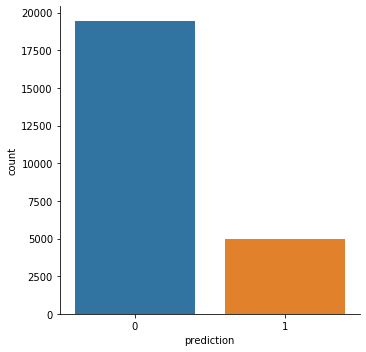

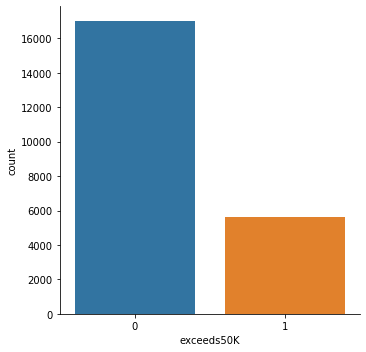

In [37]:
y_test = final_model.predict(X_test)

res = {}
res["prediction"] = y_test
df = pd.DataFrame(res)
df.index += 1
df.index.name = 'id'
sns.catplot(x="prediction", kind="count", data=df)
sns.catplot(x="exceeds50K", kind="count", data=train)
df.head()

In [38]:
# experience name
experience = 'LightGBM_preprocessingWeiXin'

if not os.path.exists(os.path.join('dump', experience)):
    os.mkdir(os.path.join('dump', experience))

X_train.to_csv(os.path.join('dump', experience, 'X_train.csv'))
X_test.to_csv(os.path.join('dump', experience, 'X_test.csv'))
pickle.dump(final_model, open(os.path.join('dump', experience, 'model'), 'wb'))
df.to_csv(os.path.join('dump', experience, experience+'.csv'))

# Feature importance

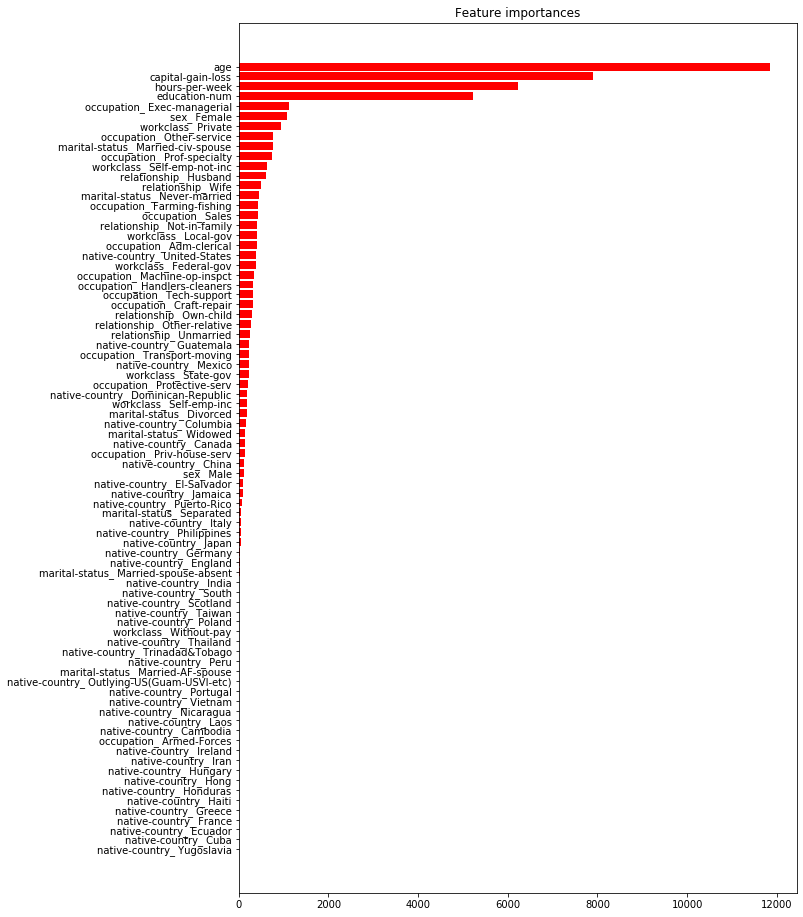

In [39]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

In [40]:
X_train = pd.read_csv(os.path.join('dump', experience, 'X_train.csv'), index_col=0)
final_model = pickle.load(open(os.path.join('dump', experience, 'model'), 'rb'))
lgb.create_tree_digraph(final_model).save(directory=os.path.join('dump', experience), filename='tree.dot')
call(['dot', '-Tpng', os.path.join('dump', experience, 'tree.dot'),
      '-o', os.path.join('dump', experience, 'tree.png'), '-Gdpi=600'])
# Display in jupyter notebook
Image(filename = os.path.join('dump', experience, 'tree.png'))